# Configuration

In [10]:
import numpy as np
import pandas as pd
from pandas import DataFrame as dataframe
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
# import shap

import xgboost
print(xgboost.__version__)
from xgboost import XGBClassifier

import pickle
import time
import json

!export PYTHONPATH="/home/hendrio/amex-1M/:$PYTHONPATH"
!export PYTHONPATH="/home/hendrio/amex-1M/src/:$PYTHONPATH"


import sys
sys.path.append('/home/hendrio/amex-1M/')
sys.path.append('/home/hendrio/amex-1M/src/')

# import trainer


2.0.3


In [11]:
base_dir = "/home/hendrio/amex-1M/"
os.listdir(base_dir)

paths={
    'data': join(base_dir, 'data'),
    'src': join(base_dir, 'data', 'src'),
    'processed': join(base_dir, 'data', 'processed'),
    'datasets': join(base_dir, 'datasets1'),
    'results': join(base_dir,'results'),
    'images': join(base_dir,'images'),
    
}


# Load Dataset

In [12]:
def load_amex_1m(path, file_name='amex-1M_binary-dataset-[intents-permissions-apicalls].npz'):
    data = np.load(join(path, file_name), allow_pickle=True)
    metadata = dataframe(data['metadata'], columns=data['metadata_columns'])
    
    columns_names = data['column_names']
    sha256 = data['sha256']

    labels_ohe = OneHotEncoder().fit_transform(np.expand_dims(metadata['CLASS'].values, axis=1)).toarray()

    print(data['data'].shape, labels_ohe.shape)

    # if ("CLASS" not in metadata.columns):
    #     print()
    #     metadata['CLASS'] = create_class(df=metadata['VT_SCANNERS_MALICIOUS'], threshold=4)
    
    print(metadata['CLASS'].value_counts())

    return data['data'], labels_ohe, metadata, columns_names, sha256


def create_class(df, threshold):
    return np.asarray([1 if i>=threshold else 0 for i in df ])

In [13]:
dataset_name = 'amex-1M-[intents-permissions-opcodes]'

In [14]:
data, labels_ohe, metadata, columns_names, sha256 = load_amex_1m(
    path=paths['processed'], 
    file_name=f'{dataset_name}.npz'
    )

(1340515, 853) (1340515, 2)
CLASS
0    1221421
1     119094
Name: count, dtype: int64


# Eval

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import clone
from scipy import stats

import trainer

def stratified_k_fold_evaluation(model, data, labels_ohe, k=10, path_save=None, dir_name=None):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)
    confusion_matrices, classification_reports = [], []
    folds_report, cm_report = {}, {}

    fold = 1

    if path_save is not None:
        if dir_name is None:
            raise Exception("Provid a 'dir_name' parameter to save results. ")
        
        os.makedirs(join(path_save, dir_name), exist_ok=True)
        os.makedirs(join(path_save, dir_name, 'KFold'), exist_ok=True)

    for train_index, test_index in skf.split(data, np.argmax(labels_ohe, axis=1)):
        print(f'fold {fold}')
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels_ohe[train_index], labels_ohe[test_index]

        # Clone the model to ensure a fresh model for each fold
        model_fold = clone(model)
        model_fold.fit(X_train, y_train)
        y_pred = model_fold.predict(X_test)

        # Calculate confusion matrix and classification report
        cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), output_dict=True)
        print(cm)
        print(report)
        confusion_matrices.append(cm)
        classification_reports.append(report)
        folds_report[f'fold-{fold}'] = report
        cm_report[f'fold-{fold}'] = cm.tolist()

        # pd.DataFrame(cm).to_csv(join(path_save, dir_name, 'KFold', f'confusion_matrix_fold_{fold}.csv'))
        # pd.DataFrame(report).to_csv(join(path_save, dir_name, 'KFold', f'classification_report_fold_{fold}.csv'))
        
        fold += 1

    with open(join(path_save, dir_name, 'KFold', f'classification_report_folds.json'), 'w') as f:
        json.dump(folds_report, f, indent=4)

    with open(join(path_save, dir_name, 'KFold', f'cm_folds.json'), 'w') as f:
        json.dump(cm_report, f, indent=4)

    # Aggregate confusion matrices and classification reports
    # final_confusion_matrix = np.mean(confusion_matrices, axis=0)
    # Using SUM
    final_confusion_matrix = np.sum(confusion_matrices, axis=0)

    print(f'confusion matrix for fold {fold}')
    print(final_confusion_matrix)
    
    trainer.plot_confusion_matrix(
        final_confusion_matrix, 
        class_labels=['Benign', 'Malware'], 
        path_save=os.path.join(path_save, f'{dir_name}-confusion_matrix')
        )

    final_classification_report = {}

    # Calculate mean and confidence intervals for each metric
    for key in classification_reports[0].keys():
        metrics = [report[key] for report in classification_reports]
        if isinstance(metrics[0], dict):  # Handle nested dicts for per-class metrics
            final_classification_report[key] = {}
            for metric in metrics[0].keys():
                
                if metric=="support": ## does not aggregate support information
                    continue

                values = [m[metric] for m in metrics]
                mean = np.mean(values)
                std_dev = np.std(values)
                conf_int = stats.t.interval(0.95, len(values)-1, loc=mean, scale=stats.sem(values))
                margin = conf_int[1] - mean
                final_classification_report[key][metric] = {
                    'mean': mean,
                    'std_dev': std_dev,
                    '95% CI': conf_int,
                    'margin': margin
                }
        else:
            values = metrics
            mean = np.mean(values)
            std_dev = np.std(values)
            conf_int = stats.t.interval(0.95, len(values)-1, loc=mean, scale=stats.sem(values))
            margin = conf_int[1] - mean
            final_classification_report[key] = {
                'mean': mean,
                'std_dev': std_dev,
                '95% CI': conf_int,
                'margin': margin
            }
    if path_save is not None:
        # Save final aggregated results
        pd.DataFrame(final_confusion_matrix).to_csv(join(path_save, dir_name,'final_confusion_matrix.csv'))
        pd.DataFrame(final_classification_report).to_csv(join(path_save, dir_name,'final_classification_report.csv'))
        with open(os.path.join(path_save, f'{dir_name}-report.json'), 'w') as f:
            json.dump(final_classification_report, f, indent=4)

    return final_confusion_matrix, final_classification_report


# Example usage:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()
# data = np.random.rand(100, 10)  # Example data
# labels_ohe = np.eye(3)[np.random.choice(3, 100)]  # Example one-hot encoded labels
# stratified_k_fold_evaluation(model, data, labels_ohe)


In [16]:
print(dataset_name)

amex-1M-[intents-permissions-opcodes]


fold 1
[[121287    856]
 [  2507   9402]]
{'0': {'precision': 0.9797486146339888, 'recall': 0.9929918210621976, 'f1-score': 0.9863257663547982, 'support': 122143.0}, '1': {'precision': 0.9165529342951843, 'recall': 0.7894869426484171, 'f1-score': 0.8482879956692381, 'support': 11909.0}, 'accuracy': 0.9749127204368454, 'macro avg': {'precision': 0.9481507744645865, 'recall': 0.8912393818553074, 'f1-score': 0.9173068810120182, 'support': 134052.0}, 'weighted avg': {'precision': 0.9741343950986233, 'recall': 0.9749127204368454, 'f1-score': 0.9740626758295219, 'support': 134052.0}}
fold 2
[[121296    846]
 [  2467   9443]]
{'0': {'precision': 0.9800667404636281, 'recall': 0.9930736356044604, 'f1-score': 0.9865273174599947, 'support': 122142.0}, '1': {'precision': 0.9177762659150549, 'recall': 0.792863140218304, 'f1-score': 0.8507590432001442, 'support': 11910.0}, 'accuracy': 0.9752857100229761, 'macro avg': {'precision': 0.9489215031893414, 'recall': 0.8929683879113821, 'f1-score': 0.91864

(array([[1213312,    8109],
        [  25134,   93960]]),
 {'0': {'precision': {'mean': 0.979705452790169,
    'std_dev': 0.00041803973820660304,
    '95% CI': (0.9793902289274551, 0.9800206766528828),
    'margin': 0.0003152238627138759},
   'recall': {'mean': 0.9933610117798782,
    'std_dev': 0.0003077368002209771,
    '95% CI': (0.9931289621109137, 0.9935930614488427),
    'margin': 0.00023204966896450685},
   'f1-score': {'mean': 0.9864858769903672,
    'std_dev': 0.00019131686579204775,
    '95% CI': (0.986341614050925, 0.9866301399298093),
    'margin': 0.0001442629394421413}},
  '1': {'precision': {'mean': 0.9205724163725192,
    'std_dev': 0.0032317849823710384,
    '95% CI': (0.9181354811902942, 0.9230093515547442),
    'margin': 0.0024369351822249863},
   'recall': {'mean': 0.7889566463960996,
    'std_dev': 0.004471311942368061,
    '95% CI': (0.785585042950172, 0.7923282498420273),
    'margin': 0.0033716034459276845},
   'f1-score': {'mean': 0.8496852224433118,
    'std_d

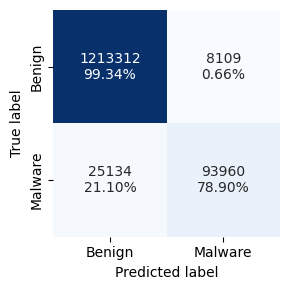

In [17]:
stratified_k_fold_evaluation(
    model=XGBClassifier(n_jobs=-1, random_state=0), 
    data=data, 
    labels_ohe=labels_ohe, 
    k=10, 
    path_save=join(paths['results'], 'models'), 
    dir_name=f'{dataset_name}-XGBClassifier-KFold10')